In [1]:
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from matplotlib import pyplot as plt

In [2]:
# loading the data
df = read_csv("https://files.codingninjas.in/international-airline-passengers-7703.csv", usecols = [1])
df.describe()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [3]:
# getting the values
values = df.values.astype('float32')
values.shape

(144, 1)

In [4]:
# splitting into training and testing
# 1. setting the sizes
train_size = int((values.shape[0] * 0.67))
test_size = values.shape[0] - train_size
train_size, test_size

# 2. splitting the datas
train = values[0:train_size]
test = values[train_size:]

train.shape

(96, 1)

In [5]:
# Scaling the data
scaler = MinMaxScaler(feature_range = (0, 1))

train = scaler.fit_transform(train)
test = scaler.transform(test)

In [6]:
"""
Creating the actual data
The form for the RNN i.e., a couple of i/ps combined using a windowsize 'k' and gives an output
Eg:- [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] -> {[1, 2, 3, 4] -> [5], [6, 7, 8, 9] -> [10] 
"""
def create_datasets(data, k):
    dataX, dataY = [], []
    for i in range(data.shape[0] - k):
        x = data[i:i + k, 0]
        y = data[i + k, 0]
        dataX.append(x)
        dataY.append(y)
        
    return np.array(dataX), np.array(dataY)

In [7]:
"""
Created an actual dataset
Format:-
Input = 12 months data
Output = corresponding 12 months travelled passengers value 
"""
look_back = 12
trainX, trainY = create_datasets(train, look_back)
testX, testY = create_datasets(test, look_back)

In [8]:
trainX.shape, testX.shape

((84, 12), (36, 12))

In [9]:
"""
RNN requires data in 3D format.
1) no. of training data points
2) length of sequence
3) no. of features in each time frame
"""
# Reshaping the data
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [10]:
trainX.shape, testX.shape

((84, 12, 1), (36, 12, 1))

In [11]:
# Creating the model
"""
Note: In RNN, we need to pass the input shape. As it is our input layer.
In this case, the dataset have 12 months data each, where each month is a single feature.
Thus, we pass the window size and the number of features as the input shape. 
"""
model = Sequential()

model.add(SimpleRNN(4, input_shape = (look_back, 1)))
model.add(Dense(1))

In [12]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [13]:
model.fit(trainX, trainY, epochs = 10, batch_size = 1)

Epoch 1/10
84/84 [==============================] - 3s 5ms/step - loss: 0.0237
Epoch 2/10
84/84 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 3/10
84/84 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 4/10
84/84 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 5/10
84/84 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 6/10
84/84 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 7/10
84/84 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 8/10
84/84 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 9/10
84/84 [==============================] - 0s 5ms/step - loss: 0.0080
Epoch 10/10
84/84 [==============================] - 0s 5ms/step - loss: 0.0082


In [14]:
# Predicted values
# ravel() - converts to 1D
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict).ravel()

trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict).ravel()

testTrue = scaler.inverse_transform([testY]).ravel()
trainTrue = scaler.inverse_transform([trainY]).ravel()

testPredict.shape, testTrue.shape

3/3 [==============================] - 0s 4ms/step


((36,), (36,))

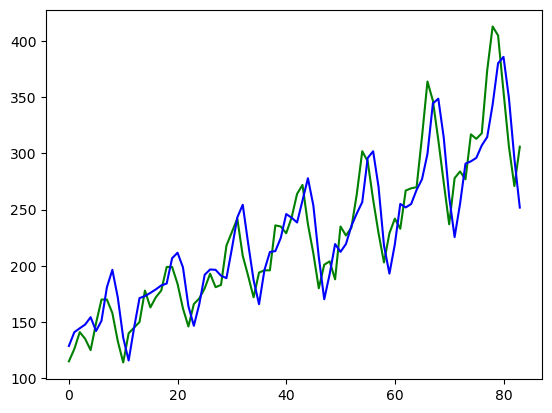

In [15]:
# Plotting the data
plt.plot(trainTrue, c = 'g')
plt.plot(trainPredict, c = 'b')
plt.show()

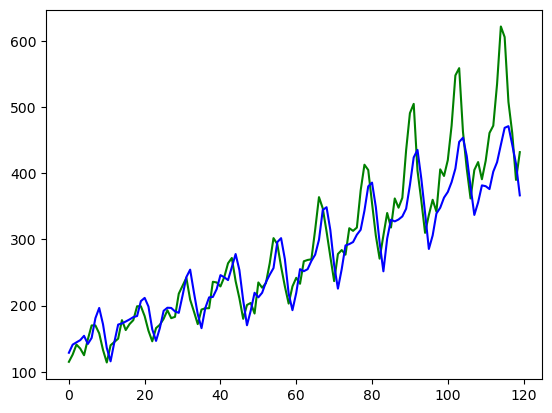

In [16]:
combinedPredicted = np.concatenate((trainPredict, testPredict))
combinedTrue = np.concatenate((trainTrue, testTrue))

plt.plot(combinedTrue, c = 'g')
plt.plot(combinedPredicted, c = 'b')
plt.show()